# KNO for 1D Burgers

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/data_driven/mindspore_burgers_KNO1D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/data_driven/mindspore_burgers_KNO1D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_en/data_driven/burgers_KNO1D.ipynb)

## Overview

Computational fluid dynamics is one of the most important techniques in the field of fluid mechanics in the 21st century. The flow analysis, prediction and control can be realized by solving the governing equations of fluid mechanics by numerical method. Traditional finite element method (FEM) and finite difference method (FDM) are inefficient because of the complex simulation process (physical modeling, meshing, numerical discretization, iterative solution, etc.) and high computing costs. Therefore, it is necessary to improve the efficiency of fluid simulation with AI.

Machine learning methods provide a new paradigm for scientific computing by providing a fast solver similar to traditional methods. Classical neural networks learn mappings between finite dimensional spaces and can only learn solutions related to a specific discretization. Different from traditional neural networks, Fourier Neural Operator (FNO) is a new deep learning architecture that can learn mappings between infinite-dimensional function spaces. It directly learns mappings from arbitrary function parameters to solutions to solve a class of partial differential equations. Therefore, it has a stronger generalization capability. More information can be found in the paper, [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).

But these kinds of neural operator become less accurate and explainable while learning long-term behaviours of non-linear PDE families. Koopman neural operator (KNO), a new neural operator, overcome these challenges by formulating a non-linear dynamic system of equation solution. By approximating the Koopman operator, an infnite-dimensional linear operator governing all possible observations of the dynamic system, to act on the flow mapping of dynamic system, we can equivalently learn the solution of an entire non-linear PDE family by solving simple linear prediction problems. More information can be found in these papers:

- "[Koopman neural operator as a mesh-free solver of non-linear partial differential equations](https://arxiv.org/abs/2301.10022)." arXiv preprint arXiv:2301.10022 (2023).
- "[KoopmanLab: machine learning for solving complex physics equations](https://arxiv.org/abs/2301.01104)." arXiv preprint arXiv:2301.01104 (2023).

This tutorial describes how to solve the 1-d Burgers' equation using Koopman neural operator.

## Burgers' equation

The 1-d Burgers’ equation is a non-linear PDE with various applications including modeling the one
dimensional flow of a viscous fluid. It takes the form

$$
\partial_t u(x, t)+\partial_x (u^2(x, t)/2)=\nu \partial_{xx} u(x, t), \quad x \in(0,1), t \in(0, 1]
$$

$$
u(x, 0)=u_0(x), \quad x \in(0,1)
$$

where $u$ is the velocity field, $u_0$ is the initial condition and $\nu$ is the viscosity coefficient.


## Problem Description

We aim to learn the operator mapping the initial condition to the solution at time one:

$$
u_0 \mapsto u(\cdot, 1)
$$

## Technology Path

MindSpore Flow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer and Loss Function.
4. Model Training.
5. Model Evaluation and Visualization.

## Koopman Neural Operator

The following figure shows the architecture of the Koopman Neural Operator, which contains the upper and lower main branches and corresponding outputs. In the figure, Input represents the initial vorticity. In the upper branch, the input vector is lifted to higher dimension channel space by the Encoding layer. Then the mapping result is used as the input of the Koopman layer to perform nonlinear transformation of the frequency domain information. Finally, the Decoding layer maps the transformation result to the Prediction. At the same time, the lower branch does high-dimensional mapping of the input vector through the Encoding Layer, and then reconstructs the input through the Decoding Layer. The Encoding layers of the upper and lower branches share the weight, and the Decoding layers share the weight too. Prediction is used to calculate the prediction error with Label, and Reconstruction is used to calculate the reconstruction error with Input. The two errors together guide the gradient calculation of the model.

The Koopman Neural Operator consists of the Encoding Layer, Koopman Layers, Decoding Layer and two branches.

The Koopman Layer is shown in the dotted box, which could be repeated. Start from input: apply the Fourier transform(FFT); apply a linear transformation on the lower Fourier modes and filters out the higher modes; then apply the inverse Fourier transform(iFFT). Then the output is added into input. Finally, the Koopman Layer output vector is obtained through the activation function.

![Fourier Layer structure](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindflow/docs/source_en/data_driven/images/kno.jpg)

In [1]:
import os
import time
import datetime
import numpy as np

import mindspore
from mindspore import nn, context, ops, Tensor, set_seed
from mindspore.nn import MSELoss

from mindflow.cell import KNO1D
from mindflow.common import get_warmup_cosine_annealing_lr
from mindflow.utils import load_yaml_config

The following `src` pacakage can be downloaded in [applications/data_driven/burgers/kno1d/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/data_driven/burgers/kno1d/src).

In [2]:
from src.dataset import create_training_dataset
from src.trainer import BurgersWithLoss
from src.utils import visual

set_seed(0)
np.random.seed(0)

print("pid:", os.getpid())
print(datetime.datetime.now())

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend', device_id=1)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

pid: 9647
2023-03-04 08:03:20.885806


You can get hyperparameters of model, data and optimizer from [config](https://gitee.com/mindspore/mindscience/blob/r0.7/MindFlow/applications/data_driven/burgers/kno1d/configs/kno1d.yaml).

In [3]:
config = load_yaml_config('kno1d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]

## Training Dataset Construction

Download the training and test dataset: [data_driven/burgers/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/burgers/dataset/).

In this case, training datasets and test datasets are generated according to Zongyi Li's dataset in [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf). The settings are as follows:

the initial condition $u_0(x)$ is generated according to periodic boundary conditions:

$$
u_0 \sim \mu, \mu=\mathcal{N}\left(0,625(-\Delta+25 I)^{-2}\right)
$$

We set the viscosity to $\nu=0.1$ and solve the equation using a split step method where the heat equation part is solved exactly in Fourier space then the non-linear part is advanced, again in Fourier space, using a very fine forward Euler method. The number of samples in the training set is 1000, and the number of samples in the test set is 200.


In [4]:
# create training dataset
train_dataset = create_training_dataset(data_params, shuffle=True)

# create test dataset
eval_dataset = create_training_dataset(
    data_params, shuffle=False, is_train=False)

Data preparation finished
input_path:  (1000, 1024, 1)
label_path:  (1000, 1024)
Data preparation finished
input_path:  (200, 1024, 1)
label_path:  (200, 1024)


## Model Construction

The network is composed of 1 shared Encoding Layer, multiple Koopman Layers and 1 shared Decoding Layer:

- The Encoding Layer corresponds to the `KNO2D.enc` in the case, and maps the output data to the high dimension;
- Koopman Layer corresponds to the `KNO2D.koopman_layer` in the case. Discrete Fourier transform is used to realize the conversion between time domain and frequency domain;
- The Decoding Layer corresponds to `KNO2D.dec` in the case to obtain the final predictive value.

Initialize the model based on the network above. Hyperparameters can be modified in config.

In [5]:
model = KNO1D(in_channels=data_params['in_channels'],
              channels=model_params['channels'],
              modes=model_params['modes'],
              depths=model_params['depths'],
              resolution=model_params['resolution']
              )

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}:{v}")
model_name = "_".join(model_params_list)
print(model_name)

name:KNO1D_channels:32_modes:64_depths:4_resolution:1024


## Optimizer and Loss Function

Use the mean square error as the training loss function:

In [6]:
train_size = train_dataset.get_dataset_size()
eval_size = eval_dataset.get_dataset_size()

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["lr"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=train_size,
                                    warmup_epochs=1)
optimizer = nn.AdamWeightDecay(model.trainable_params(),
                               learning_rate=Tensor(lr),
                               weight_decay=optimizer_params["weight_decay"])
model.set_train()
loss_fn = MSELoss()
if use_ascend:
    from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O3')
else:
    loss_scaler = None

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [7]:
problem = BurgersWithLoss(model, data_params["out_channels"], loss_fn)

def forward_fn(inputs, labels):
    loss, l_recons, l_pred = problem.get_loss(inputs, labels)
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss, l_recons, l_pred

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(inputs, labels):
    (loss, l_recons, l_pred), grads = grad_fn(inputs, labels)
    if use_ascend:
        loss = loss_scaler.unscale(loss)
        if all_finite(grads):
            grads = loss_scaler.unscale(grads)
    loss = ops.depend(loss, optimizer(grads))
    return loss, l_recons, l_pred

def eval_step(inputs, labels):
    return problem.get_rel_loss(inputs, labels)

train_sink = mindspore.data_sink(train_step, train_dataset, sink_size=1)
eval_sink = mindspore.data_sink(eval_step, eval_dataset, sink_size=1)

summary_dir = os.path.join(config["summary_dir"], model_name)
os.makedirs(summary_dir, exist_ok=True)
print(summary_dir)

for epoch in range(1, optimizer_params["epochs"] + 1):
    time_beg = time.time()
    l_recons_train = 0.0
    l_pred_train = 0.0
    for _ in range(train_size):
        _, l_recons, l_pred = train_sink()
        l_recons_train += l_recons.asnumpy()
        l_pred_train += l_pred.asnumpy()
    l_recons_train = l_recons_train / train_size
    l_pred_train = l_pred_train / train_size
    print(f"epoch: {epoch}, time cost: {(time.time() - time_beg):>8f},"
          f" recons loss: {l_recons_train:>8f}, pred loss: {l_pred_train:>8f}")

    if epoch % config['eval_interval'] == 0:
        l_recons_eval = 0.0
        l_pred_eval = 0.0
        print("---------------------------start evaluation-------------------------")
        for _ in range(eval_size):
            l_recons, l_pred = eval_sink()
            l_recons_eval += l_recons.asnumpy()
            l_pred_eval += l_pred.asnumpy()
        l_recons_eval = l_recons_eval / eval_size
        l_pred_eval = l_pred_eval / eval_size
        print(f'Eval epoch: {epoch}, recons loss: {l_recons_eval},'
              f' relative pred loss: {l_pred_eval}')
        print("---------------------------end evaluation---------------------------")
        mindspore.save_checkpoint(model, ckpt_file_name=summary_dir + '/save_model.ckpt')

./summary_dir/name:KNO1D_channels:32_modes:64_depths:4_resolution:1024
epoch: 1, time cost: 18.375901, recons loss: 0.295517, pred loss: 0.085093
epoch: 2, time cost: 2.577698, recons loss: 0.161718, pred loss: 0.002227
epoch: 3, time cost: 2.564470, recons loss: 0.027144, pred loss: 0.000992
epoch: 4, time cost: 2.547690, recons loss: 0.000782, pred loss: 0.000511
epoch: 5, time cost: 2.532924, recons loss: 0.000057, pred loss: 0.000279
epoch: 6, time cost: 2.536904, recons loss: 0.000048, pred loss: 0.000241
epoch: 7, time cost: 2.527330, recons loss: 0.000048, pred loss: 0.000213
epoch: 8, time cost: 2.536032, recons loss: 0.000048, pred loss: 0.000227
epoch: 9, time cost: 2.462490, recons loss: 0.000048, pred loss: 0.000230
epoch: 10, time cost: 2.564090, recons loss: 0.000049, pred loss: 0.000229
---------------------------start evaluation-------------------------
Eval epoch: 10, recons loss: 4.7733558130858e-05, relative pred loss: 0.01156728882342577
---------------------------e

## Model Evaluation and Visualization

Take 6 samples, and do 10 consecutive steps of prediction. Visualize the prediction as follows.

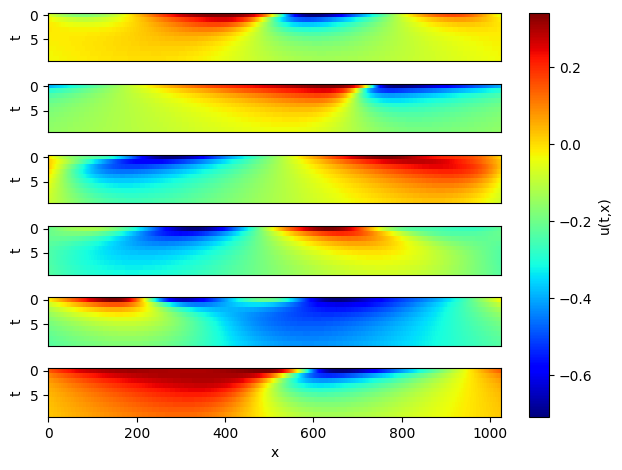

In [8]:
# Infer and plot some data.
inputs = np.load(os.path.join(data_params["path"], "test/inputs.npy"))  # (200,1024,1)
problem = BurgersWithLoss(model, 10, loss_fn)
visual(problem, inputs)